In [11]:
# !pip install matplotlib pandas wordcloud
import os
from pyspark.find_spark_home import _find_spark_home
from pyspark.sql import SparkSession
from pyspark import SparkConf, StorageLevel
import pyspark.sql.functions as F
from pyspark.sql.functions import col, count

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from dotenv import load_dotenv
load_dotenv()

print(_find_spark_home())

C:\Users\yan4etooo\anaconda3\envs\bigdata\Lib\site-packages\pyspark


In [12]:
python_path = os.environ.get('PYTHON_PATH')
app_name_nov = os.environ.get('APP_NAME_NOV')
hadoop_path_nov = os.environ.get('HADOOP_NOV_DATASET_PATH')

In [13]:
conf = SparkConf()\
    .setMaster('local[*]')\
    .set('spark-local-dir', "C:\\spark-temp")\
    .set('spark.driver.memory', '4g')\
    .set('spark.executor.memory', '4g')\
    .set('spark.driver.maxResultSize', '2g')\
    .set('spark.pyspark.python', python_path)\
    .set('spark.pyspark.driver.python', python_path)\
    .set("spark.network.timeout","800s")\
    .set("spark.dynamicAllocation.enabled", "true")\
    .set("spark.shuffle.service.enabled", "true")\
    .set("spark.dynamicAllocation.minExecutors", "1")\
    .set("spark.dynamicAllocation.maxExecutors", "10")\
    .set("spark.dynamicAllocation.executorIdleTimeout", "60s")\

spark = SparkSession.builder.appName(app_name_dec).config(conf=conf).getOrCreate()
sc = spark.sparkContext

for item in sc.getConf().getAll(): print(item)

('spark.dynamicAllocation.minExecutors', '1')
('spark.app.startTime', '1703766033633')
('spark.driver.memory', '4g')
('spark.app.name', 'eCommerce')
('spark.dynamicAllocation.maxExecutors', '10')
('spark.sql.warehouse.dir', 'file:/C:/Users/yan4etooo/Documents/GitHub/FlightPrices/3-queries/spark-warehouse')
('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-o

In [14]:
df = spark.read.csv(hadoop_path_nov+'/selected_Data/', header = True, inferSchema = True)
df.show()

+------------+----------+----------+----------+-------+---------+-----------+--------------------+---+
|          id|event_type|product_id|     brand|  price|  user_id|   category|             product|day|
+------------+----------+----------+----------+-------+---------+-----------+--------------------+---+
|403727064801|      view|   1004239|     apple|1413.16|554666475|electronics|          smartphone| 18|
| 42950433984|      view|   1004250|     apple| 741.04|527029321|electronics|          smartphone|  4|
| 34360364567|      view|   1004886|      oppo| 128.67|543083998|electronics|          smartphone|  4|
|360777911454|      view|   1480156|       neo| 666.66|519293476|  computers|             desktop| 17|
| 85900085278|      view|   6400162|     intel| 215.58|533512255|  computers|      components.cpu|  7|
|180389410990|      view|   1201284|    lenovo| 154.19|570911983|electronics|              tablet| 13|
| 17180281985|      view|   3900339|      aqua|  30.86|517565940| applian

### Question:
Which are the most sold categories of products for each month? Which were the most sold brands?

In [15]:
df_sales = df.filter(col("event_type") == "purchase")

df_grouped = df_sales.groupBy("category").agg(count("id").alias("sales_count"))

df_top10 = df_grouped.orderBy(col("sales_count").desc()).limit(10)

df_top10.show()

+------------+-----------+
|    category|sales_count|
+------------+-----------+
| electronics|     490519|
|  appliances|      94338|
|   computers|      33371|
|     apparel|      11711|
|        auto|       8612|
|construction|       6463|
|   furniture|       5727|
|        kids|       5078|
| accessories|       1886|
|       sport|       1006|
+------------+-----------+



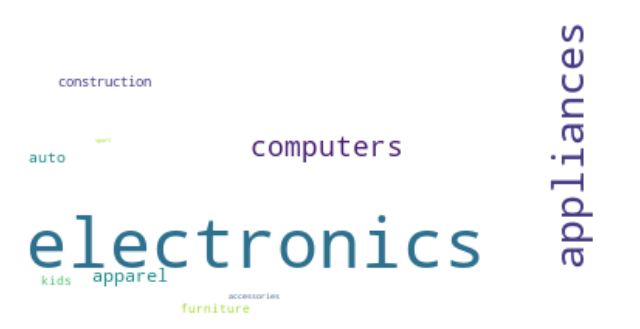

In [16]:
rows = df_top10.collect()
frequencies = {row['category']: row['sales_count'] for row in rows}

wc = WordCloud(background_color="white")
wc.generate_from_frequencies(frequencies)

fig = plt.figure()
fig.set_figwidth(8)
fig.set_figheight(10)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [17]:
for row in df_top10.collect():
    print(row)

Row(category='electronics', sales_count=490519)
Row(category='appliances', sales_count=94338)
Row(category='computers', sales_count=33371)
Row(category='apparel', sales_count=11711)
Row(category='auto', sales_count=8612)
Row(category='construction', sales_count=6463)
Row(category='furniture', sales_count=5727)
Row(category='kids', sales_count=5078)
Row(category='accessories', sales_count=1886)
Row(category='sport', sales_count=1006)


In [18]:
df_sales = df.filter(col("event_type") == "view")

df_grouped = df_sales.groupBy("category").agg(count("id").alias("view_count"))

df_top10 = df_grouped.orderBy(col("view_count").desc()).limit(10)

df_top10.show()

+------------+----------+
|    category|view_count|
+------------+----------+
| electronics|  21573622|
|  appliances|   7567716|
|   computers|   3898545|
|     apparel|   2346203|
|   furniture|    976963|
|        auto|    948067|
|construction|    817318|
|        kids|    630310|
| accessories|    329952|
|       sport|    181009|
+------------+----------+



In [19]:
df_sales = df.filter(col("event_type") == "purchase")

df_grouped = df_sales.groupBy("brand").agg(count("id").alias("sales_count_brand"))

df_top10 = df_grouped.orderBy(col("sales_count_brand").desc()).limit(10)

df_top10.show()

+-------+-----------------+
|  brand|sales_count_brand|
+-------+-----------------+
|samsung|           198670|
|  apple|           165681|
| xiaomi|            57909|
| huawei|            23466|
|   oppo|            15080|
|     lg|            11828|
|  artel|             7269|
| lenovo|             6546|
|   acer|             6402|
|  bosch|             5718|
+-------+-----------------+



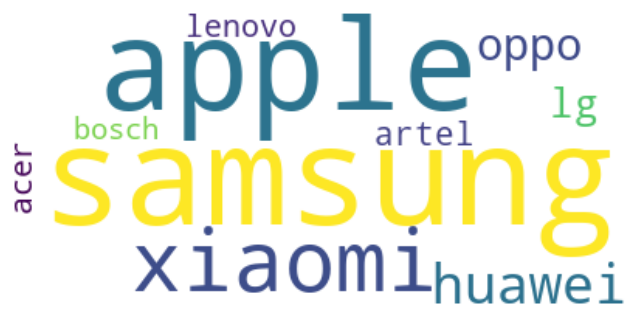

In [20]:
rows = df_top10.collect()
frequencies = {row['brand']: row['sales_count_brand'] for row in rows}

wc = WordCloud(background_color="white")
wc.generate_from_frequencies(frequencies)

fig = plt.figure()
fig.set_figwidth(8)
fig.set_figheight(10)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [21]:
df_sales = df.filter(col("event_type") == "view")

df_grouped = df_sales.groupBy("brand").agg(count("id").alias("view_count_brand"))

df_top10 = df_grouped.orderBy(col("view_count_brand").desc()).limit(10)

df_top10.show()

+-------+----------------+
|  brand|view_count_brand|
+-------+----------------+
|samsung|         6942176|
|  apple|         5559896|
| xiaomi|         3856216|
| huawei|         1287644|
|     lg|          965779|
|   oppo|          751991|
|respect|          710829|
| lenovo|          699389|
|   acer|          672128|
|  bosch|          578298|
+-------+----------------+



### Question:
What was the period of time with most purchases?
- During which part of the month - beginning, mid, end

In [22]:
#  checking nr of purchases each day

purchases = df.filter(col("event_type") == "purchase")

daily_purchases = purchases.groupBy("day").count()
sorted_daily_purchases = daily_purchases.orderBy("day")

sorted_daily_purchases.show(n=sorted_daily_purchases.count())

+---+------+
|day| count|
+---+------+
|  1| 16257|
|  2| 15446|
|  3| 15975|
|  4| 18479|
|  5| 16614|
|  6| 17290|
|  7| 16837|
|  8| 18595|
|  9| 16297|
| 10| 16140|
| 11| 17355|
| 12| 16207|
| 13| 16429|
| 14| 16519|
| 16| 51205|
| 17|134611|
| 18| 20728|
| 19| 18047|
| 20| 17652|
| 21| 17183|
| 22| 17153|
| 23| 16312|
| 24| 16671|
| 25| 17099|
| 26| 17184|
| 27| 17687|
| 28| 17841|
| 29| 24365|
| 30| 21078|
+---+------+



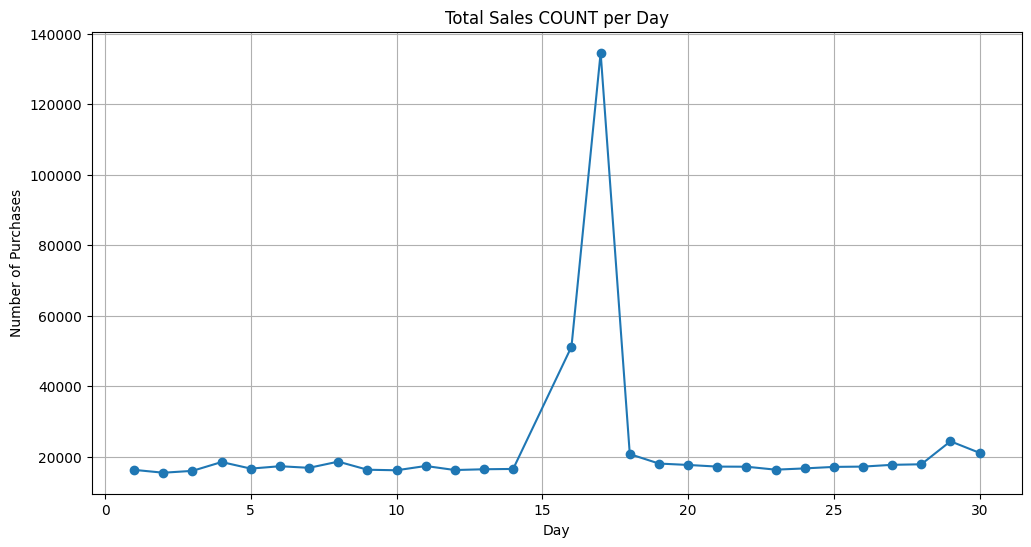

In [23]:
pandas_df = sorted_daily_purchases.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(pandas_df['day'], pandas_df['count'], marker='o')
plt.title('Total Sales COUNT per Day')
plt.xlabel('Day')
plt.ylabel('Number of Purchases')
plt.grid(True)
plt.show()

In [24]:
purchases = df.filter(F.col("event_type") == "purchase")

daily_purchases_sum = purchases.groupBy("day").agg(F.sum("price").alias("total_sales"))

formatted_daily_purchases_sum = daily_purchases_sum.select(
    "day",
    F.format_number("total_sales", 2).alias("total_sales_formatted")
)
sorted_daily_purchases_sum = formatted_daily_purchases_sum.orderBy("day")
daily_ordered = daily_purchases_sum.orderBy("day")

sorted_daily_purchases_sum.show(n=sorted_daily_purchases_sum.count())

+---+---------------------+
|day|total_sales_formatted|
+---+---------------------+
|  1|         6,139,652.74|
|  2|         5,611,469.00|
|  3|         5,897,819.72|
|  4|         7,113,880.10|
|  5|         6,348,667.88|
|  6|         6,541,083.22|
|  7|         6,173,308.11|
|  8|         6,866,347.90|
|  9|         5,849,829.89|
| 10|         5,866,407.89|
| 11|         6,371,107.15|
| 12|         5,960,772.82|
| 13|         6,016,036.40|
| 14|         6,207,215.37|
| 16|        20,471,443.84|
| 17|        49,733,051.07|
| 18|         7,341,581.24|
| 19|         6,455,003.43|
| 20|         6,259,855.03|
| 21|         6,086,597.42|
| 22|         6,161,270.77|
| 23|         5,553,303.81|
| 24|         5,758,434.84|
| 25|         6,201,917.30|
| 26|         6,057,475.12|
| 27|         6,303,812.38|
| 28|         6,343,652.83|
| 29|         8,648,807.74|
| 30|         7,220,587.07|
+---+---------------------+



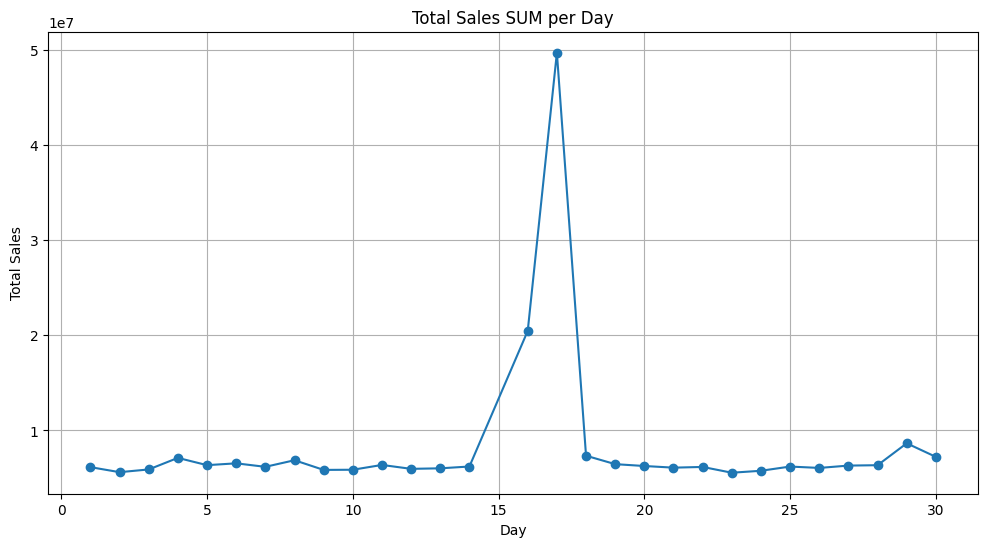

In [25]:
pandas_df = daily_ordered.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(pandas_df['day'], pandas_df['total_sales'], marker='o')
plt.title('Total Sales SUM per Day')
plt.xlabel('Day')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()


### Question:
Total price of sales for the month

In [26]:
total_sales_sum = daily_ordered.agg(F.sum("total_sales").alias("total_sales_sum"))

total_sales_sum_value = total_sales_sum.collect()[0]["total_sales_sum"]
formatted_total_sales_sum = f"{total_sales_sum_value:,.2f}"

print("Total Sales Sum:", formatted_total_sales_sum)

Total Sales Sum: 241,560,392.08
